# Definitions

In [ ]:
def move_to_start_position(stages, motor, start, offset, reset_encoder=False):
    stages.set_motor_parameter(motor, "EncLoopMax", 1)
    stages.set_motor_command(motor, "Config", None)
    stages.set_motor_status(motor, "Enabled", 1)

    pos = start + offset
    stages.set_motor_command(motor, "MoveToPosition", pos)
    while not stages.get_motor_command(motor, "HasPositionReached"):
        pass

    pos = start
    stages.set_motor_command(motor, "MoveToPosition", pos)
    while not stages.get_motor_command(motor, "HasPositionReached"):
        pass

    if reset_encoder:
        stages.set_motor_status(motor, "EncoderPosition", pos)

In [2]:
import numpy as np
import csv

def save_csv(filename: str, **arrays: np.ndarray) -> None:
    """
    Save multiple 1D numpy arrays as columns in a CSV file, 
    using keyword argument names as headers.
    """
    if not arrays:
        raise ValueError("At least one array must be provided.")

    # Convert to 1D numpy arrays
    arrays = {k: np.asarray(v).ravel() for k, v in arrays.items()}

    # Check lengths
    length = len(next(iter(arrays.values())))
    if any(len(v) != length for v in arrays.values()):
        raise ValueError("All arrays must have the same length.")

    # Write CSV
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        # header
        writer.writerow(arrays.keys())
        # rows
        for row in zip(*arrays.values()):
            writer.writerow(row)

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

def create_figure():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel("Commanded Position")
    ax.set_ylabel("Actual Position")
    ax.set_title("Motor Command vs Actual Position")
    ax.grid(True)

    # create scatter with dummy point
    scatter = ax.scatter([0], [0], c=["white"], label="Motor Response")

    # clear initial dummy point
    scatter.set_offsets(np.empty((0, 2)))
    scatter.set_facecolors(np.empty((0, 4)))  # RGBA empty

    ax.plot([], [], "r--", label="Ideal")
    ax.legend()
    return fig, ax, scatter

def autoscale_axis(ax):
    # --- update scaling ---
    ax.relim()             # recompute limits based on current scatter data
    ax.autoscale_view()    # apply new limits

def add_point(fig, ax, scatter, commanded, actual, color="blue"):
    # get current offsets
    offsets = scatter.get_offsets()
    new_offsets = np.vstack([offsets, [commanded, actual]])
    scatter.set_offsets(new_offsets)

    # update colors
    old_colors = scatter.get_facecolors()
    new_color = np.array([plt.matplotlib.colors.to_rgba(color)])
    new_colors = np.vstack([old_colors, new_color]) if len(old_colors) else new_color
    scatter.set_facecolors(new_colors)

    # redraw
    clear_output(wait=True)
    display(fig)
    fig.canvas.flush_events()
    return None

def add_points(fig, ax, scatter, commanded_list, actual_list, color="blue"):
    # convert inputs to Nx2 array
    new_offsets = np.column_stack([commanded_list, actual_list])

    # get current offsets and append
    offsets = scatter.get_offsets()
    if len(offsets):
        all_offsets = np.vstack([offsets, new_offsets])
    else:
        all_offsets = new_offsets
    scatter.set_offsets(all_offsets)

    # update colors
    new_color = np.array([plt.matplotlib.colors.to_rgba(color)])
    new_colors = np.repeat(new_color, len(new_offsets), axis=0)

    old_colors = scatter.get_facecolors()
    if len(old_colors):
        all_colors = np.vstack([old_colors, new_colors])
    else:
        all_colors = new_colors
    scatter.set_facecolors(all_colors)

    # redraw
    clear_output(wait=True)
    display(fig)
    fig.canvas.flush_events()
    return None

# Device Comm

### Open the device

In [ ]:
import importlib
import picostage
from picostage import PicoStage
import logging, sys
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time


logger = logging.getLogger("StageDriverLogger")
logger.setLevel(logging.INFO)
logger.handlers.clear()
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [5]:
# open the connection
stages = PicoStage('ASRL9::INSTR', logger=logger)
stages.get_error()
logger.setLevel(logging.ERROR)

2025-09-27 07:38:43,313 [INFO] Initializing instrument.
2025-09-27 07:38:43,559 [INFO] Instrument: SerialInstrument at ASRL9::INSTR
2025-09-27 07:38:43,577 [INFO] Requesting ID from instrument
2025-09-27 07:38:43,582 [INFO] Checking for errors.


### Close the device

In [ ]:
stages.close()
del stages

### Various

In [ ]:
# clear the stages
motor = -1 # all motors
stages.get_error() # get errors to clear them but don't display them
stages.set_motor_command(-1, "StatusClear", None)
stages.get_error()

'PC_EMSG=No error'

In [ ]:
# disable the remote control for all axes
stages.set_remote_parameter(-1, "RemoteEnabled", 0)
stages.get_error()

'PC_EMSG=No error'

In [ ]:
motor = 1
stages.set_motor_status(motor, "Enabled", 1)

### Disable all motors

In [ ]:
motor = -1 # all motors
stages.set_motor_status(motor, "Enabled", 0)

In [ ]:
# close the device
stages.close()
del stages

### Goto pos

In [10]:
move_to_start_position(stages, motor, 0, -1000, True)
print(stages.get_motor_status(motor, "ActualPosition"))
print(stages.get_motor_status(motor, "EncoderPosition"))

0
0


# Axis Test

In [7]:
axis = 'Y'
motor = 1

## Unidirectional

Set the initial condition

In [11]:

move_to_start_position(stages, motor, 0, -1000, True)

Set the mode

In [12]:
stages.set_motor_parameter(motor, "EncLoopMax", 1)
stages.set_motor_command(motor, "Config", None)
stages.set_motor_status(motor, "Enabled", 1)

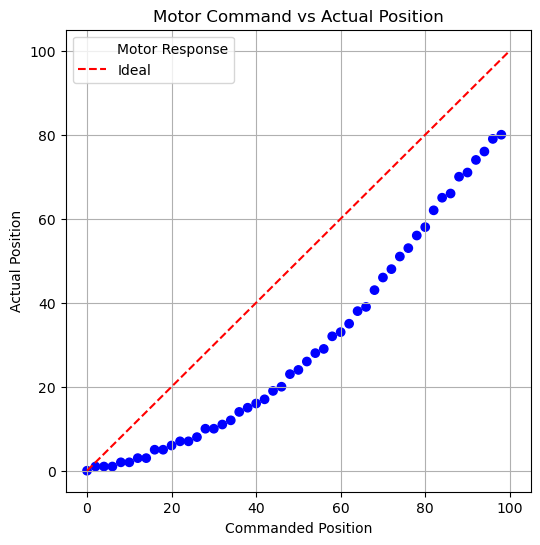

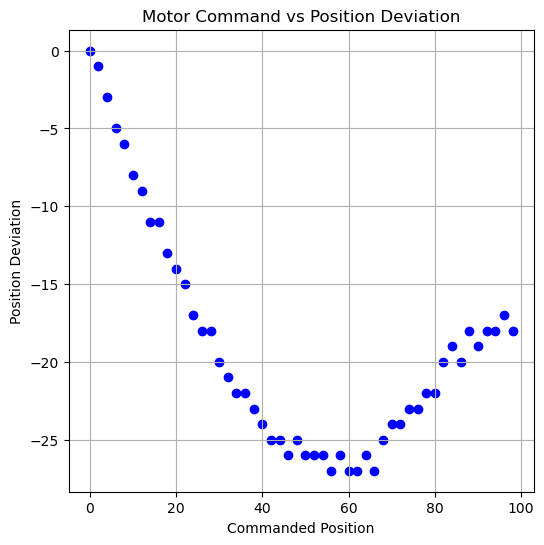

In [13]:
# Parameters
num_steps = 50
step_size = 2   # motor units per step

# Data storage
commanded_positions = []
actual_positions = []
fig, ax, scatter = create_figure()
ax.plot([0, num_steps*step_size], [0, num_steps*step_size], "r--", label="Ideal")


for i in range(num_steps):
    commanded = i * step_size
    stages.set_motor_command(motor, "MoveToPosition", commanded)
    while not stages.get_motor_command(motor, "HasPositionReached"):
        pass
    actual = stages.get_motor_status(motor, "EncoderPosition")

    # store in memory
    commanded_positions.append(commanded)
    actual_positions.append(actual)
    add_point(fig, ax, scatter, commanded, actual, "blue")

plt.close(fig) # otherwise Jupyter shows another copy of the figure

plt.figure(figsize=(6, 6))
pos_deviation = np.array(actual_positions) - np.array(commanded_positions)
plt.scatter(commanded_positions, pos_deviation, c="blue")
plt.xlabel("Commanded Position")
plt.ylabel("Position Deviation")
plt.title("Motor Command vs Position Deviation")
plt.grid(True)
plt.show()


In [16]:
save_csv(axis+f'AxisOpenLoopUnidirectional_Step_{step_size}.csv',
         target=commanded_positions,
         encoder=actual_positions)

## Bidirectional Open Loop

Set the initial condition

In [14]:
offset = 0
move_to_start_position(stages, motor, 0, -5000 + offset, True)

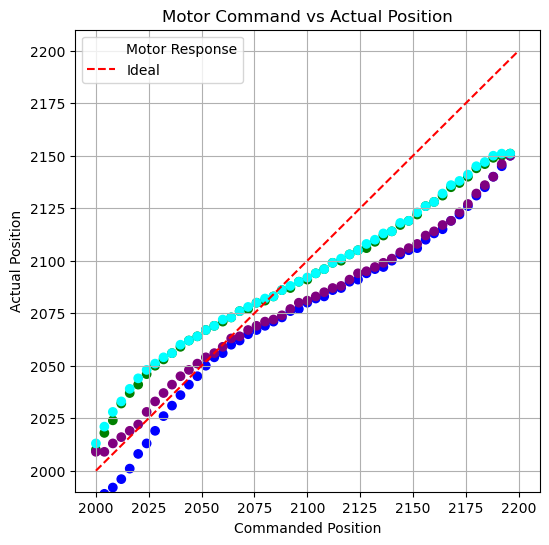

In [30]:
# Parameters
num_steps = 50
step_size = 4   # motor units per step

# Data storage
commanded_positions = []
actual_positions = []
fig, ax, scatter = create_figure()
ax.plot([offset, num_steps*step_size + offset], [offset, num_steps*step_size + offset], "r--", label="Ideal")
autoscale_axis(ax)

# Define excursions: (range, color)
excursions = [
    (range(num_steps), "blue"),
    (reversed(range(num_steps)), "green"),
    (range(num_steps), "purple"),
    (reversed(range(num_steps)), "cyan"),
]

for positions, color in excursions:
    for i in positions:
        commanded = i * step_size + offset
        stages.set_motor_command(motor, "MoveToPosition", commanded)
        # wait for motion to complete
        while not stages.get_motor_command(motor, "HasPositionReached"):
            pass
        actual = stages.get_motor_status(motor, "EncoderPosition")

        # store in memory
        commanded_positions.append(commanded)
        actual_positions.append(actual)
        add_point(fig, ax, scatter, commanded, actual, color)

plt.close(fig) # otherwise Jupyter shows another copy of the figure


In [ ]:
save_csv(axis+f'AxisOpenLoopBidirectional_Steps_{num_steps}_StepSize_{step_size}_Offset{offset}.csv',
         target=commanded_positions,
         encoder=actual_positions)

## Bidirectional Closed Loop

Set the mode

In [47]:
offset = 0
move_to_start_position(stages, motor, 0, -5000 + offset, True)

In [48]:
tolerance = 1
reset = 1
stages.set_motor_parameter(motor, "EncLoopMax", 10)
stages.set_motor_parameter(motor, "EncLoopTolerance", tolerance)
stages.set_motor_parameter(motor, "EncResetXafterCL", reset)
stages.set_motor_command(motor, "Config", None)
stages.set_motor_status(motor, "Enabled", 1)

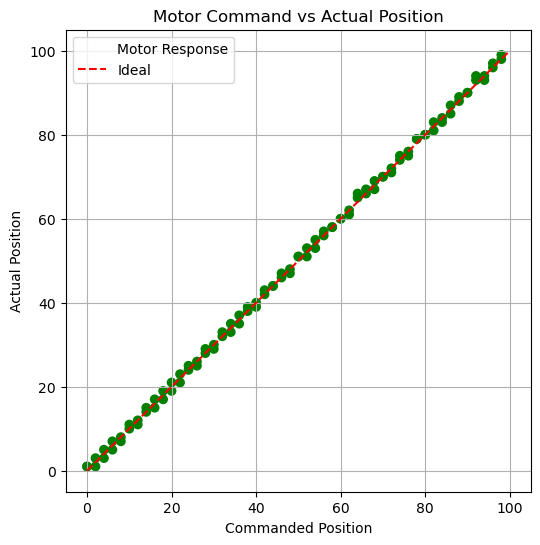

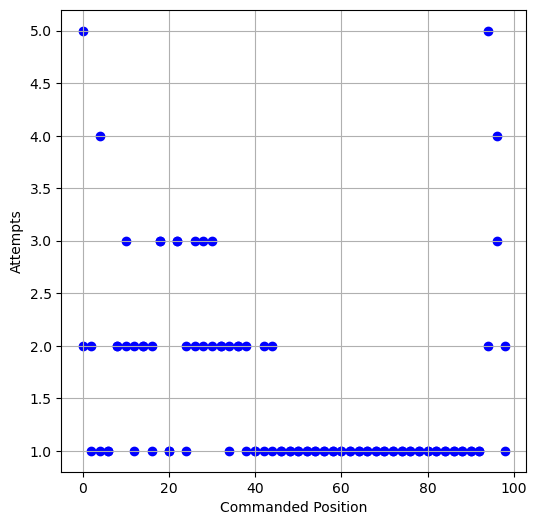

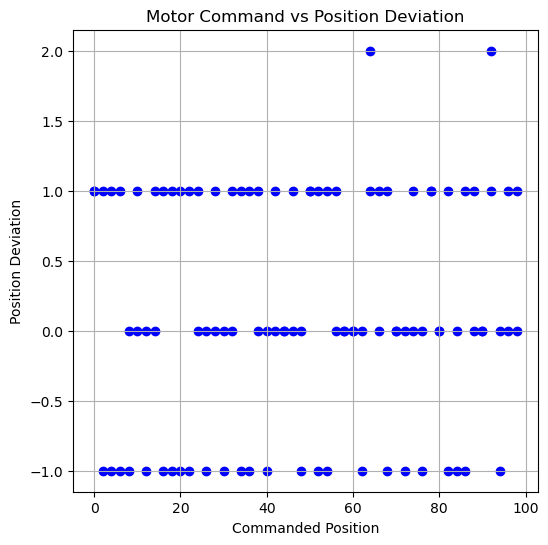

Elapsed time: 17.011811700009275 seconds


In [ ]:
# Parameters
num_steps = 50
step_size = 2   # motor units per step
sleep_time = 0

# Data storage
commanded_positions = []
actual_positions = []
attempts =[]
fig, ax, scatter = create_figure()
ax.plot([offset, num_steps*step_size + offset], [offset, num_steps*step_size + offset], "r--", label="Ideal")
autoscale_axis(ax)

# Define excursions: (range, color)
excursions = [
    ([offset + i * step_size for i in range(num_steps)], "blue"),
    ([offset + i * step_size for i in reversed(range(num_steps))], "green"),
]

total_points = sum(len(pos_list) for pos_list, _ in excursions)
commanded_positions = np.empty(total_points, dtype=int)
actual_positions    = np.empty(total_points, dtype=int)
attempts            = np.empty(total_points, dtype=int)

start_time = time.perf_counter()

idx = 0
for positions, color in excursions:
    for commanded in positions:
        stages.set_motor_command(motor, "MoveToPosition", commanded)
        # wait for motion to complete
        while not stages.get_motor_command(motor, "HasPositionReached"):
            pass
        # stages.get_motor_command(motor, "HasPositionReached")
        # wait for a bit
        time.sleep(sleep_time)
        actual = stages.get_motor_status(motor, "EncoderPosition")
        num_attempts = stages.get_motor_status(motor, "LastPullInTries")
        # store in memory
        commanded_positions[idx] = commanded
        actual_positions[idx]    = actual
        attempts[idx]            = num_attempts

        idx += 1
        # add_point(fig, ax, scatter, commanded, actual, color) # do not use when timing

end_time = time.perf_counter()

add_points(fig, ax, scatter, commanded_positions, actual_positions, color) # only use when timing

plt.close(fig) # otherwise Jupyter shows another copy of the figure

plt.figure(figsize=(6, 6))
plt.scatter(commanded_positions, attempts, c="blue")
plt.xlabel("Commanded Position")
plt.ylabel("Attempts")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
pos_deviation = np.array(actual_positions) - np.array(commanded_positions)
plt.scatter(commanded_positions, pos_deviation, c="blue")
plt.xlabel("Commanded Position")
plt.ylabel("Position Deviation")
plt.title("Motor Command vs Position Deviation")
plt.grid(True)
plt.show()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [31]:
save_csv(axis+f'AxisPIBidirectional_Steps_{num_steps}_StepSize_{step_size}_Tol_{tolerance}{'_Reset' if reset==1 else ''}.csv',
         target=commanded_positions,
         encoder=actual_positions,
         attempts=attempts)

## Random

Set the mode

In [15]:
tolerance = 2
reset = 0
sleep_time = 2
stages.set_motor_parameter(motor, "EncLoopMax", 0)
stages.set_motor_parameter(motor, "EncLoopTolerance", tolerance)
stages.set_motor_parameter(motor, "EncResetXafterCL", reset)
stages.set_motor_command(motor, "Config", None)
stages.set_motor_status(motor, "Enabled", 1)


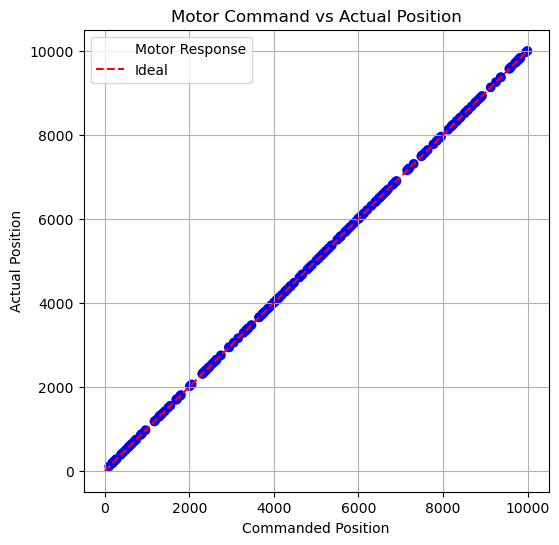

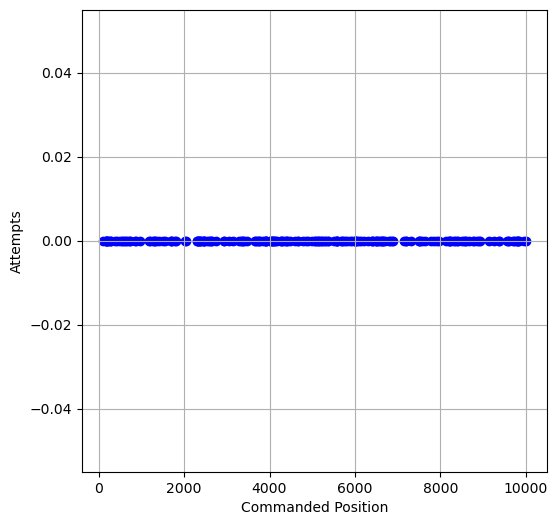

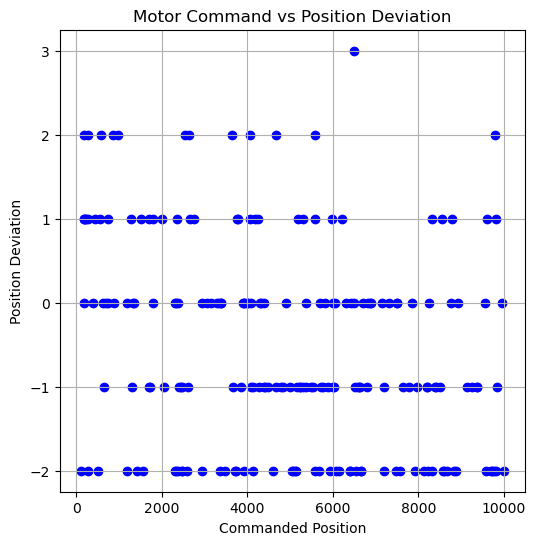

In [16]:
import numpy as np

# Parameters
excursion = 10000
num_pts = 200

commanded_positions = np.random.randint(0, excursion, num_pts)
actual_positions = []
attempts = []
fig, ax, scatter = create_figure()
ax.plot([0, excursion], [0, excursion], "r--")

for commanded in commanded_positions:
    stages.set_motor_command(motor, "MoveToPosition", commanded)
    # wait for motion to complete
    # while not stages.get_motor_command(motor, "HasPositionReached"):
    #     pass
    # wait for a bit
    time.sleep(sleep_time)
    actual = stages.get_motor_status(motor, "EncoderPosition")
    # num_attempts = stages.get_motor_status(motor, "LastPullInTries")
    num_attempts = 0
    # store in memory
    actual_positions.append(actual)
    attempts.append(num_attempts)
    add_point(fig, ax, scatter, commanded, actual, color="blue")

plt.close(fig) # otherwise Jupyter shows another copy of the figure

plt.figure(figsize=(6, 6))
plt.scatter(commanded_positions, attempts, c="blue")
plt.xlabel("Commanded Position")
plt.ylabel("Attempts")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
pos_deviation = np.array(actual_positions) - np.array(commanded_positions)
plt.scatter(commanded_positions, pos_deviation, c="blue")
plt.xlabel("Commanded Position")
plt.ylabel("Position Deviation")
plt.title("Motor Command vs Position Deviation")
plt.grid(True)
plt.show()

In [34]:
save_csv(axis+f'AxisOpenLoopRandom_Tol_{tolerance}_Delay_{sleep_time}.csv',
         target=commanded_positions,
         encoder=actual_positions,
         attempts=attempts)

In [28]:
save_csv(axis+f'AxisOLPullInRandom_Tol_{tolerance}_Delay_{sleep_time}.csv',
         target=commanded_positions,
         encoder=actual_positions,
         attempts=attempts)

In [17]:
save_csv(axis+f'AxisClosedLoopRandom_Tol_{tolerance}_Delay_{sleep_time}.csv',
         target=commanded_positions,
         encoder=actual_positions,
         attempts=attempts)

# Param Handling

In [7]:
importlib.reload(picostage)
from picostage import PicoStage

In [2]:
# open the connection
stages = PicoStage('ASRL9::INSTR', logger=logger)
stages.get_error()
logger.setLevel(logging.ERROR)

2025-09-25 15:10:17,237 [INFO] Initializing instrument.
2025-09-25 15:10:17,332 [INFO] Instrument: SerialInstrument at ASRL9::INSTR
2025-09-25 15:10:17,348 [INFO] Requesting ID from instrument
2025-09-25 15:10:17,355 [INFO] Checking for errors.


In [5]:
stages.close()
del stages

In [44]:
stages.save_parameters_to_file("Config_2025-09-10.json")

In [ ]:
stages.load_parameters_from_file("Config_2025-09-08.json")

In [3]:
motor_param_list = stages.get_pico_names("MP_")
print(motor_param_list)

['MP_CSCA', 'MP_CRAN', 'MP_CRUN', 'MP_CHOL', 'MP_MMIC', 'MP_MINV', 'MP_MTOF', 'MP_MSGE', 'MP_MSGT', 'MP_MTCT', 'MP_HMOD', 'MP_HDIR', 'MP_HVEL', 'MP_HSST', 'MP_HNEV', 'MP_RSEV', 'MP_RMXV', 'MP_RSEA', 'MP_RMXA', 'MP_ECON', 'MP_EDEV', 'MP_ETOL', 'MP_EMAX', 'MP_ERST', 'MP_SLEN', 'MP_SREN', 'MP_SLPO', 'MP_SRPO', 'MP_SSWP', 'MP_LENC', 'MP_LLEN', 'MP_LREN', 'MP_LLPS', 'MP_LRPS', 'MP_TDEV', 'MP_TAXI']


In [4]:
motor_param_list = stages.get_param_names("MP_C")
print(motor_param_list)

['CurrScaler', 'CurrRange', 'CurrRun', 'CurrHold']
